In [11]:
!pip install transformers -i https://pypi.tuna.tsinghua.edu.cn/simple

In [1]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification, TFRobertaModel, AutoTokenizer
from transformers import InputExample, InputFeatures
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [3]:
df = pd.read_csv('../data/processed/reviews_processed.csv')

def convert_label(label):
    if label in [1, 2]:
        return 0  
    elif label == 3:
        return 1  
    else:
        return 2  


df['Label'] = df['Label'].apply(convert_label)


train_df, temp_test_df = train_test_split(df, test_size=0.4, stratify=df['Label'], random_state=42)


test_df, validation_df = train_test_split(temp_test_df, test_size=0.5, stratify=temp_test_df['Label'], random_state=42)


tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")


def encode_reviews(reviews, max_length=128):
    return tokenizer(reviews, padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")


train_encodings = encode_reviews(train_df['Review'].tolist())
test_encodings = encode_reviews(test_df['Review'].tolist())
validation_encodings = encode_reviews(validation_df['Review'].tolist())


train_dataset = tf.data.Dataset.from_tensor_slices((
    {key: train_encodings[key] for key in ['input_ids', 'attention_mask']},
    train_df['Label'].values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    {key: test_encodings[key] for key in ['input_ids', 'attention_mask']},
    test_df['Label'].values
))

validation_dataset = tf.data.Dataset.from_tensor_slices((
    {key: validation_encodings[key] for key in ['input_ids', 'attention_mask']},
    validation_df['Label'].values
))


train_dataset = train_dataset.shuffle(len(train_df)).batch(16)
test_dataset = test_dataset.batch(16)
validation_dataset = validation_dataset.batch(16)

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Bidirectional
from tensorflow.keras.models import Model
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


roberta = TFRobertaModel.from_pretrained('roberta-base')

input_ids = Input(shape=(None,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(None,), dtype=tf.int32, name="attention_mask")

outputs = roberta(input_ids, attention_mask=attention_mask)

sequence_output = outputs.last_hidden_state

bidirectional_lstm_layer_1 = Bidirectional(LSTM(256, return_sequences=True))(sequence_output)

bidirectional_lstm_layer_2 = Bidirectional(LSTM(128, return_sequences=False))(bidirectional_lstm_layer_1)


output_layer = Dense(3, activation='softmax')(bidirectional_lstm_layer_2)

model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-9), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])


early_stop = EarlyStopping(
    monitor='val_loss',  
    patience=3,          
    verbose=1,           
    restore_best_weights=True  
)



class_weights = compute_class_weight(
    class_weight='balanced',  
    classes=np.unique(train_df['Label']),
    y=train_df['Label'].values  
)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed class weights:", class_weight_dict)

def warmup_and_exponential_decay(epoch, start_lr, max_lr, warmup_epochs, decay_rate):
    if epoch < warmup_epochs:
        lr = start_lr + (max_lr - start_lr) / warmup_epochs * epoch
    else:
        lr = max_lr * decay_rate ** (epoch - warmup_epochs)
    return lr

warmup_and_expo_lr_scheduler = LearningRateScheduler(lambda epoch: warmup_and_exponential_decay(epoch, start_lr=5e-9, max_lr=1e-6, warmup_epochs=4, decay_rate=0.8), verbose=1)


history = model.fit(
    train_dataset, 
    validation_data=validation_dataset, 
    epochs=50,
    callbacks=[warmup_and_expo_lr_scheduler],  
    class_weight=class_weight_dict
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['roberta.embeddings.position_ids', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Computed class weights: {0: 1.8350018539117539, 1: 1.7071403932390479, 2: 0.5349691925197276}

Epoch 1: LearningRateScheduler setting learning rate to 5e-09.
Epoch 1/50
928/928 [==============================] - 355s 363ms/step - loss: 1.1309 - accuracy: 0.1817 - val_loss: 1.1730 - val_accuracy: 0.1817 - lr: 5.0000e-09

Epoch 2: LearningRateScheduler setting learning rate to 2.5375e-07.
Epoch 2/50
928/928 [==============================] - 331s 357ms/step - loss: 1.0407 - accuracy: 0.4742 - val_loss: 0.7508 - val_accuracy: 0.7442 - lr: 2.5375e-07

Epoch 3: LearningRateScheduler setting learning rate to 5.025e-07.
Epoch 3/50
928/928 [==============================] - 300s 323ms/step - loss: 0.5762 - accuracy: 0.8165 - val_loss: 0.3874 - val_accuracy: 0.8515 - lr: 5.0250e-07

Epoch 4: LearningRateScheduler setting learning rate to 7.5125e-07.
Epoch 4/50
928/928 [==============================] - 260s 280ms/step - loss: 0.4432 - accuracy: 0.8561 - val_loss: 0.3517 - val_accuracy: 0.8654 -

310/310 [==============================] - 22s 72ms/step - loss: 0.2817 - accuracy: 0.8986
Test Loss: 0.281712144613266, Test Accuracy: 0.8985653519630432
310/310 [==============================] - 24s 71ms/step


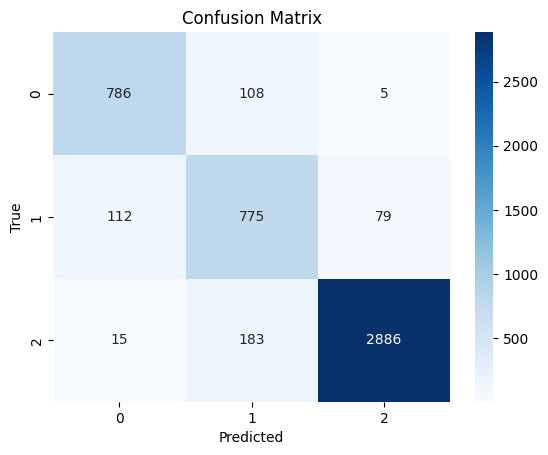

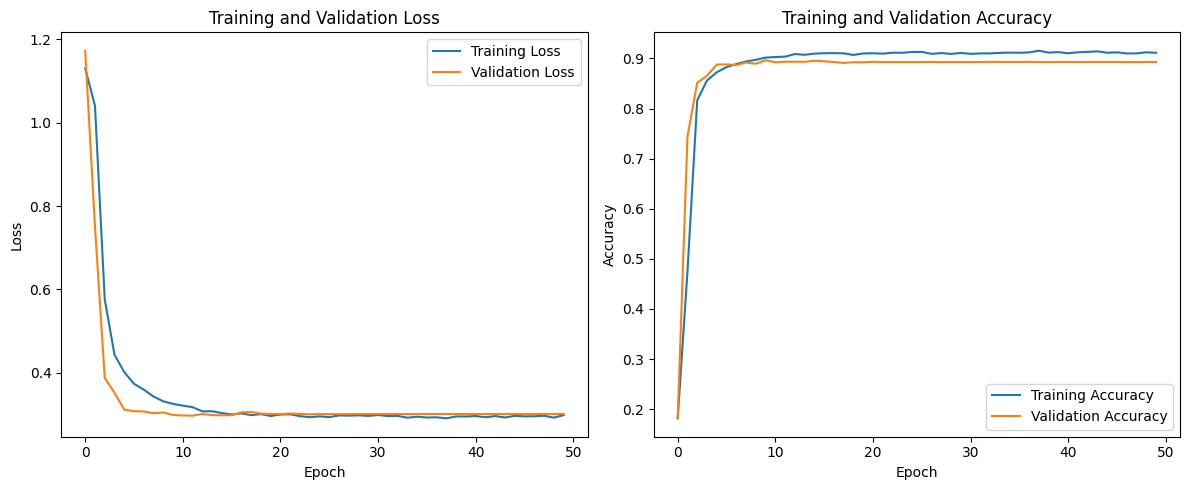

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf

loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

probabilities = model.predict(test_dataset)
y_pred = np.argmax(probabilities, axis=1)

y_true = np.concatenate([y for x, y in test_dataset], axis=0)

conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
model.save('Model_8986_50epoch.h5')


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')


print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


Precision: 0.9038, Recall: 0.8986, F1 Score: 0.9006


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

for idx, cls in enumerate(['Negative', 'Neutral', 'Positive']):
    print(f"{cls} class - Precision: {precision[idx]:.4f}, Recall: {recall[idx]:.4f}, F1 Score: {f1[idx]:.4f}")


Negative class - Precision: 0.8609, Recall: 0.8743, F1 Score: 0.8675
Neutral class - Precision: 0.7270, Recall: 0.8023, F1 Score: 0.7628
Positive class - Precision: 0.9717, Recall: 0.9358, F1 Score: 0.9534


In [10]:

train_labels_shape = train_df['Label'].values.shape
print("Train labels shape:", train_labels_shape)


test_labels_shape = test_df['Label'].values.shape
print("Test labels shape:", test_labels_shape)


validation_labels_shape = validation_df['Label'].values.shape
print("Validation labels shape:", validation_labels_shape)


Train labels shape: (14847,)
Test labels shape: (4949,)
Validation labels shape: (4949,)
